### GLM analysis : How much of the serotonin signal variance is explained by task variables?

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import seaborn as sns
import pickle
import pandas as pd 
from scipy.interpolate import interp1d
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

with open('../data_behaviour.pkl', 'rb') as fp:
    data_behaviour = pickle.load(fp)

from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict
from sklearn.metrics import r2_score

In [203]:

# Get sessions unique ids
sessions_uid = list(data_behaviour.keys())

# 7 regressors are included in the linear encoding model
regressors_labels = ['speed',
                     'wheel position',
                     'gain',
                     'trial number',
                     'gain change',
                     'delta position',
                     'gain change abs',
                     'delta position abs']

GLM_parameters = {
     "kernel_time_shift" : 0.5,
     "kernel_time_length" : 1,
     "psth_time_pre" : 1,
     "psth_time_post" : 1.5,
}

def get_regressors(data_behaviour,session_uid, psth_only=True,plots=False):
        
        running_speed = data_behaviour[session_uid]['running_speed']
        gain = data_behaviour[session_uid]['gain']
        absolute_speed = running_speed / gain
        running_speed[running_speed < -25] = None # remove unrealistically low running values
        gain = data_behaviour[session_uid]['gain']
        trial_num = data_behaviour[session_uid]['trial_num']
        wheel_position = data_behaviour[session_uid]['wheel_position']
        df_over_f =data_behaviour[session_uid]['df_over_f']
        sample_times = data_behaviour[session_uid]['sample_times']

        # time between each sample
        dt = np.median(np.diff(sample_times))

        gain_change_samples = np.where(np.diff(trial_num) > 0)[0]
        gain_change_magnitudes = [np.diff(gain)[ix] for ix in gain_change_samples]

        sinusoid_frequency = 50 / 3
        delta_position = np.mod(np.diff(wheel_position)[gain_change_samples], sinusoid_frequency) / sinusoid_frequency
        delta_position =  (-0.25 + np.abs( delta_position - 0.5 ) )*4

        gain_change_regressor = np.zeros(gain.shape[0])
        gain_change_regressor[gain_change_samples] = gain_change_magnitudes
        gain_change_regressor_abs = np.abs(gain_change_regressor)

        delta_position_regressor = np.zeros(gain.shape[0])
        delta_position_regressor[gain_change_samples] = delta_position
        delta_position_regressor_abs = np.abs(delta_position_regressor)

        true_time = sample_times[~np.isnan(absolute_speed)]
        trial_changes = np.where(np.diff(trial_num[~np.isnan(absolute_speed)]) > 0)[0]

        wheel_position = wheel_position[~np.isnan(absolute_speed)]
        gain = gain[~np.isnan(absolute_speed)]
        trial_num = trial_num[~np.isnan(absolute_speed)]
        gain_change_regressor = gain_change_regressor[~np.isnan(absolute_speed)]
        delta_position_regressor = delta_position_regressor[~np.isnan(absolute_speed)]
        gain_change_regressor_abs = gain_change_regressor_abs[~np.isnan(absolute_speed)]
        delta_position_regressor_abs = delta_position_regressor_abs[~np.isnan(absolute_speed)]
        df_over_f = df_over_f[~np.isnan(absolute_speed)]
        absolute_speed = absolute_speed[~np.isnan(absolute_speed)]


        ### crafting time-varying event-kernels
        sample_shift = np.round(GLM_parameters["kernel_time_shift"] / dt).astype(int)
        sample_length = np.round(GLM_parameters["kernel_time_length"] / dt).astype(int)
        # print("sample_shift",sample_shift)
        # print("sample_length",sample_length)

        gain_change_regressor = np.convolve(gain_change_regressor, np.concatenate([np.zeros(sample_length+2*sample_shift),np.ones(sample_length)]),"same")
        delta_position_regressor = np.convolve(delta_position_regressor, np.concatenate([np.zeros(sample_length+2*sample_shift),np.ones(sample_length)]),"same")
        gain_change_regressor_abs = np.convolve(gain_change_regressor_abs, np.concatenate([np.zeros(sample_length+2*sample_shift),np.ones(sample_length)]),"same")
        delta_position_regressor_abs = np.convolve(delta_position_regressor_abs, np.concatenate([np.zeros(sample_length+2*sample_shift),np.ones(sample_length)]),"same")

        X = np.concatenate([absolute_speed[:, None], 
                                wheel_position[:, None],
                                gain[:, None], 
                                trial_num[:, None],
                                gain_change_regressor[:, None], 
                                delta_position_regressor[:, None],
                                gain_change_regressor_abs[:, None], 
                                delta_position_regressor_abs[:, None]],
                                axis=1).T
        y = df_over_f

        if psth_only :
            time_pre = GLM_parameters["psth_time_pre"]
            time_post = GLM_parameters["psth_time_post"]
            samples_pre = np.round(time_pre / dt).astype(int)
            samples_post = np.round(time_post / dt).astype(int)
            trial_psth = []
            gain_change_samples = np.where(np.diff(trial_num) > 0)[0]
            for sample in gain_change_samples:
                trial_psth.append( np.arange((sample - samples_pre),(sample + samples_post)) )
            trial_psth = np.concatenate(trial_psth)

            X = X[:,trial_psth]
            y = y[trial_psth]

            trial_changes = np.where(np.diff(trial_num[~np.isnan(absolute_speed)][trial_psth]) > 0)[0]

        if plots :
            sigma_smooth = 1
            f = plt.figure(figsize=(20,10))

            plt.subplot(711)
            plt.plot(scipy.ndimage.gaussian_filter1d(y,sigma=sigma_smooth))
            plt.vlines(x=trial_changes,ymin=y.min(),ymax=y.max(),color='r',ls='--')
            plt.xlabel("time (s)")
            plt.ylabel('df_over_f',fontsize=10)

            plt.subplot(712)
            plt.plot(X[0])
            plt.xlabel("time (s)")
            plt.ylabel('speed')

            plt.subplot(713)
            plt.plot(X[1])
            plt.xlabel("time (s)")
            plt.ylabel('wheel_position')

            plt.subplot(714)
            plt.plot(X[2])
            plt.ylabel('gain')

            plt.subplot(715)
            plt.plot(X[3])
            plt.ylabel('trial_num')

            plt.subplot(716)
            plt.plot(X[4])
            plt.ylabel('gain change')
            plt.vlines(x=trial_changes,ymin=X[4].min(),ymax=X[4].max(),color='r',ls='--')

            plt.subplot(717)
            plt.plot(X[5])
            plt.ylabel('phase shift')
            plt.vlines(x=trial_changes,ymin=X[5].min(),ymax=X[5].max(),color='r',ls='--')


            f.tight_layout()
            plt.show()

        return X,y

In [211]:
def run_GLM_F_test(X,y):

    # First we train the full model
    cv = KFold(n_splits=10, shuffle=True, random_state=0)
    X_full = X
    reg_full = Ridge()
    y_pred_full = cross_val_predict(reg_full, X_full.T, y, cv=cv)
    SSEFull = np.sum((y - y_pred_full)**2)
    full_R2 = r2_score(y,y_pred_full)

    cvR2 = []
    deltaR2 = []
    reducedR2 = []

    for i in range(X.shape[0]):

        # Single-variable model : all variables but one are shuffled
        X_only = X.copy()
        for j in range(X.shape[0]):
            if j != i:
                np.random.shuffle(X_only[j,:])
        reg_only =  Ridge()
        y_pred_only = cross_val_predict(reg_only, X_only.T, y, cv=cv)
        single_var_R2 = r2_score(y,y_pred_only)

        # Reduced model : the variable of interest is shuffled - to assess its unique contribution
        X_reduced = X.copy()
        np.random.shuffle(X_reduced[i,:])
        reg_reduced =  Ridge()
        y_pred_reduced = cross_val_predict(reg_reduced, X_reduced.T, y, cv=cv)
        reduced_R2 = r2_score(y,y_pred_reduced)
        SSEReduced = np.sum((y - y_pred_reduced)**2)

        # computing the F-statistic for the variable of interest
        F = ((SSEFull - SSEReduced) / (-1)) / (SSEFull / (X.shape[1] - X.shape[0] - 1))
        p_value = 2*(1-scipy.stats.f.cdf(F, X_reduced.shape[1] - X_reduced.shape[0]-1, X.shape[1] - X.shape[0]-1))
        # print(regressors_labels[i],"F",F,"p",p_value)

        cvR2.append(single_var_R2)
        deltaR2.append( full_R2 - reduced_R2)
        reducedR2.append(reduced_R2)

    # print(full_R2,cvR2,deltaR2)

    return full_R2, cvR2, deltaR2,reducedR2

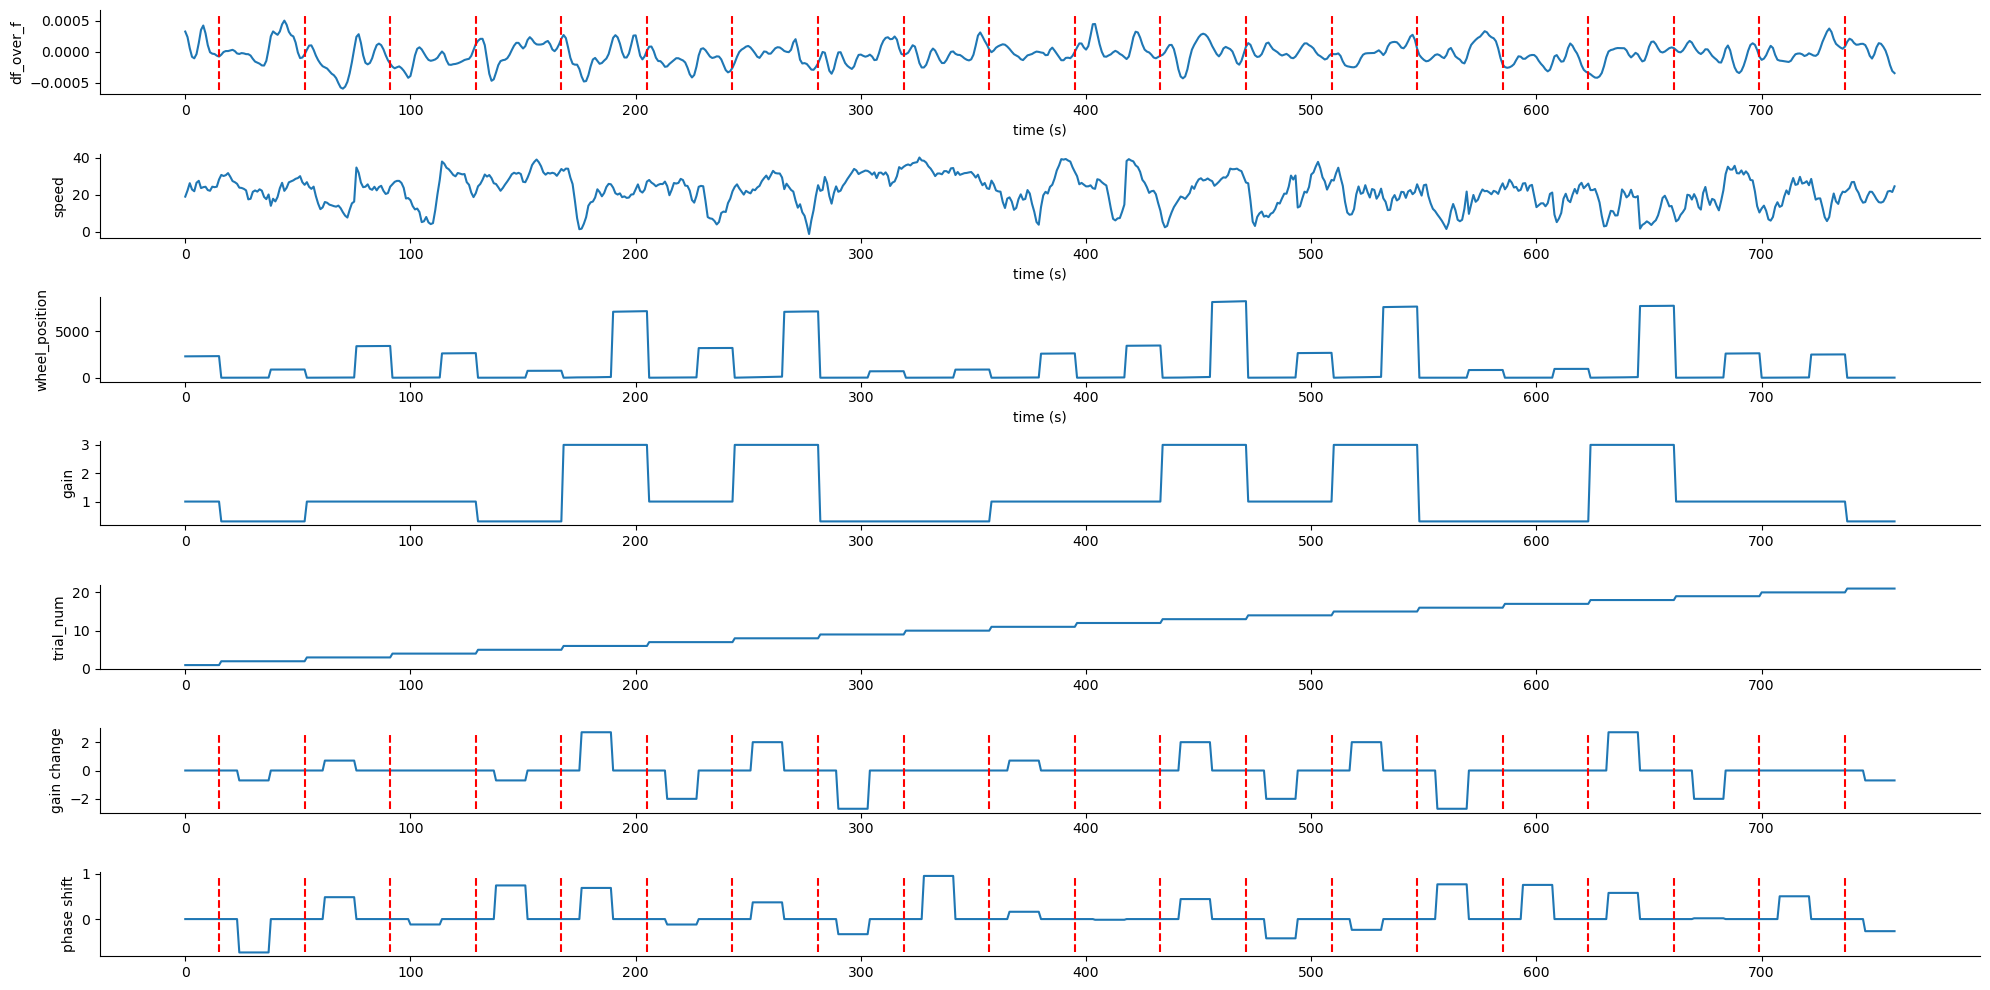

full model R²: 0.053312386933422995
speed-reduced model R²: 0.04890728045680448


In [219]:
# example with plotting
X,y = get_regressors(data_behaviour,sessions_uid[7],psth_only=True,plots=True)
fullR2, cvR2, deltaR2,reducedR2 = run_GLM_F_test(X,y)
print("full model R²:",fullR2)
print("speed-reduced model R²:",reducedR2[0])

In [221]:
dict_glm_results = {}
for session_uid in sessions_uid:
    X,y = get_regressors(data_behaviour,session_uid,psth_only=True,plots=False)
    fullR2, cvR2, deltaR2,reducedR2 = run_GLM_F_test(X,y)
    print(session_uid)
    print("full model R²:",fullR2)
    print("speed reduced model R²:",reducedR2[0])
    print("gain-change reduced model R²:",reducedR2[-2])
    print('')
    dict_glm_results[session_uid] = {"fullR2":fullR2,"cvR2":cvR2,"deltaR2":deltaR2,"reducedR2":reducedR2}

RL1_1_0
full model R²: 0.19402910967346065
speed reduced model R²: 0.1655905292055252
gain-change reduced model R²: 0.1772625544434625

RL1_1_1
full model R²: 0.2536349308979836
speed reduced model R²: 0.16627465975703482
gain-change reduced model R²: 0.21478458837392345

RL1_1_2
full model R²: 0.28596253498058055
speed reduced model R²: 0.19385217310477332
gain-change reduced model R²: 0.2754027000344569

RL1_1_3
full model R²: 0.2569082165597837
speed reduced model R²: 0.19652558600909087
gain-change reduced model R²: 0.19661193475305228

RL1_1_4
full model R²: 0.15168010155800737
speed reduced model R²: 0.12575795616043384
gain-change reduced model R²: 0.15068826029773763

RL2_1_0
full model R²: 0.08721075417713842
speed reduced model R²: 0.08416302071555493
gain-change reduced model R²: 0.08721075417713842

RL1_2_0
full model R²: 0.07110922139863662
speed reduced model R²: 0.05931261880439809
gain-change reduced model R²: 0.07184141574644054

RL1_2_1
full model R²: 0.05331238693342

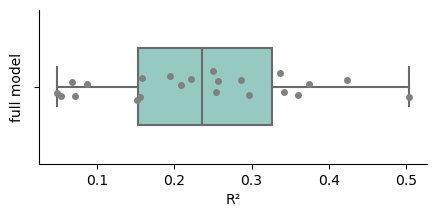

mean R² 0.23188590593976433


In [200]:
df_results = pd.DataFrame(dict_glm_results).T
df_results = df_results.explode(["deltaR2","cvR2",'reducedR2'])
df_results['label'] = df_results.groupby('fullR2').cumcount()+1
df_results['label'].replace({1:"speed",
                                 2:"wheel position",
                                 3:"gain",
                                 4:"trial number",
                                 5:"gain change",
                                 6:"delta position",
                                 7:"gain change abs",
                                 8:"delta position abs"},inplace=True)
df_results

plt.figure(figsize=(5,2))
sns.boxplot(df_results.reset_index().groupby('index').sample(), x="fullR2",palette="Set3",width=0.5)
sns.stripplot(df_results.reset_index().groupby('index').sample(), x="fullR2",color='grey')
plt.ylabel("full model")
plt.xlabel('R²')
plt.show()
print("mean R²",df_results['fullR2'].mean())

C:\Users\fphub\AppData\Local\Temp\ipykernel_15584\3871892772.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(xlabels_new)


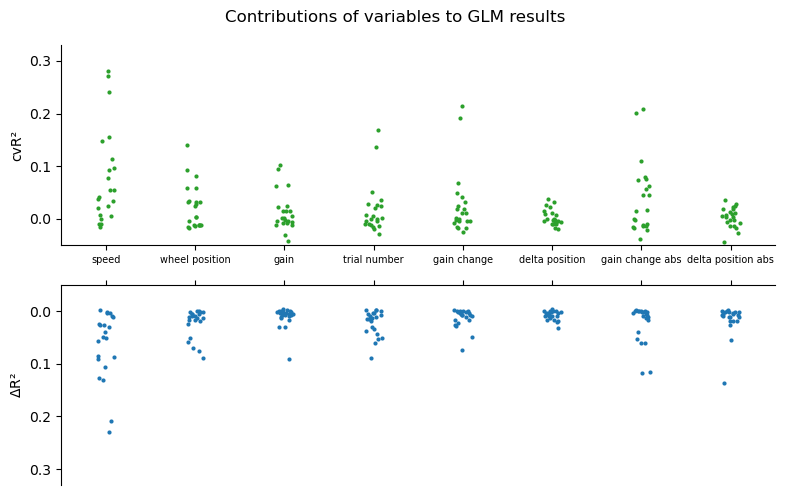

In [171]:
f,axs=plt.subplots(2,1,figsize=(8,5))

sns.stripplot(data=df_results,x="label",y="cvR2",ax=axs[0],color="tab:green",size=3)
axs[0].set_ylim(-0.05,df_results['cvR2'].max()+0.05)
xlabels_new = [label.replace('-', '-\n') for label in df_results["label"].unique()]
axs[0].set_xticklabels(xlabels_new)
axs[0].set_xlabel("")
axs[0].set_ylabel('cvR²')

sns.stripplot(data=df_results,x="label",y="deltaR2",ax=axs[1],color="tab:blue",size=3)
axs[1].set_ylim(-0.05,df_results['cvR2'].max()+0.05)
axs[1].invert_yaxis()
axs[1].xaxis.set_ticks_position("top")
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(True)
axs[1].axes.xaxis.set_ticklabels([])
axs[1].set_xlabel("")
axs[1].set_ylabel(r'$\Delta$R²')

plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=0, size=7)
f.suptitle('Contributions of variables to GLM results')
f.tight_layout()
plt.show()

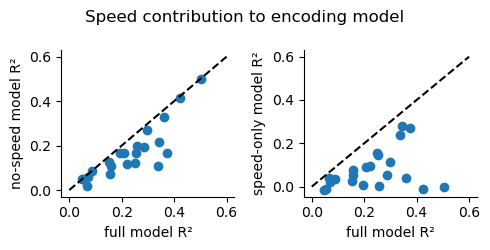

In [163]:
plt.figure(figsize=(5,2.5))
plt.subplot(121)
plt.scatter(data=df_results[df_results['label'] == "speed"],x="fullR2",y="reducedR2")
plt.plot([0,0.6],[0,0.6],ls="--",color="k")
plt.xlabel('full model R²')
plt.ylabel('no-speed model R²')
plt.subplot(122)
plt.scatter(data=df_results[df_results['label'] == "speed"],x="fullR2",y="cvR2")
plt.plot([0,0.6],[0,0.6],ls="--",color="k")
plt.xlabel('full model R²')
plt.ylabel('speed-only model R²')
plt.suptitle('Speed contribution to encoding model')
plt.tight_layout()
plt.show()

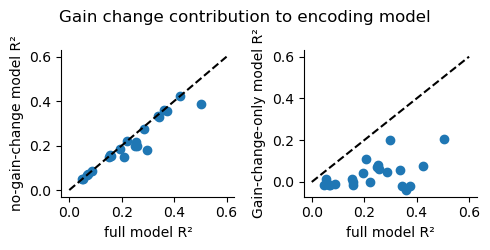

In [168]:
plt.figure(figsize=(5,2.5))
plt.subplot(121)
plt.scatter(data=df_results[df_results['label'] == "gain change abs"],x="fullR2",y="reducedR2")
plt.plot([0,0.6],[0,0.6],ls="--",color="k")
plt.xlabel('full model R²')
plt.ylabel('no-gain-change model R²')
plt.subplot(122)
plt.scatter(data=df_results[df_results['label'] == "gain change abs"],x="fullR2",y="cvR2")
plt.plot([0,0.6],[0,0.6],ls="--",color="k")
plt.xlabel('full model R²')
plt.ylabel('Gain-change-only model R²')
plt.suptitle('Gain change contribution to encoding model')
plt.tight_layout()
plt.show()

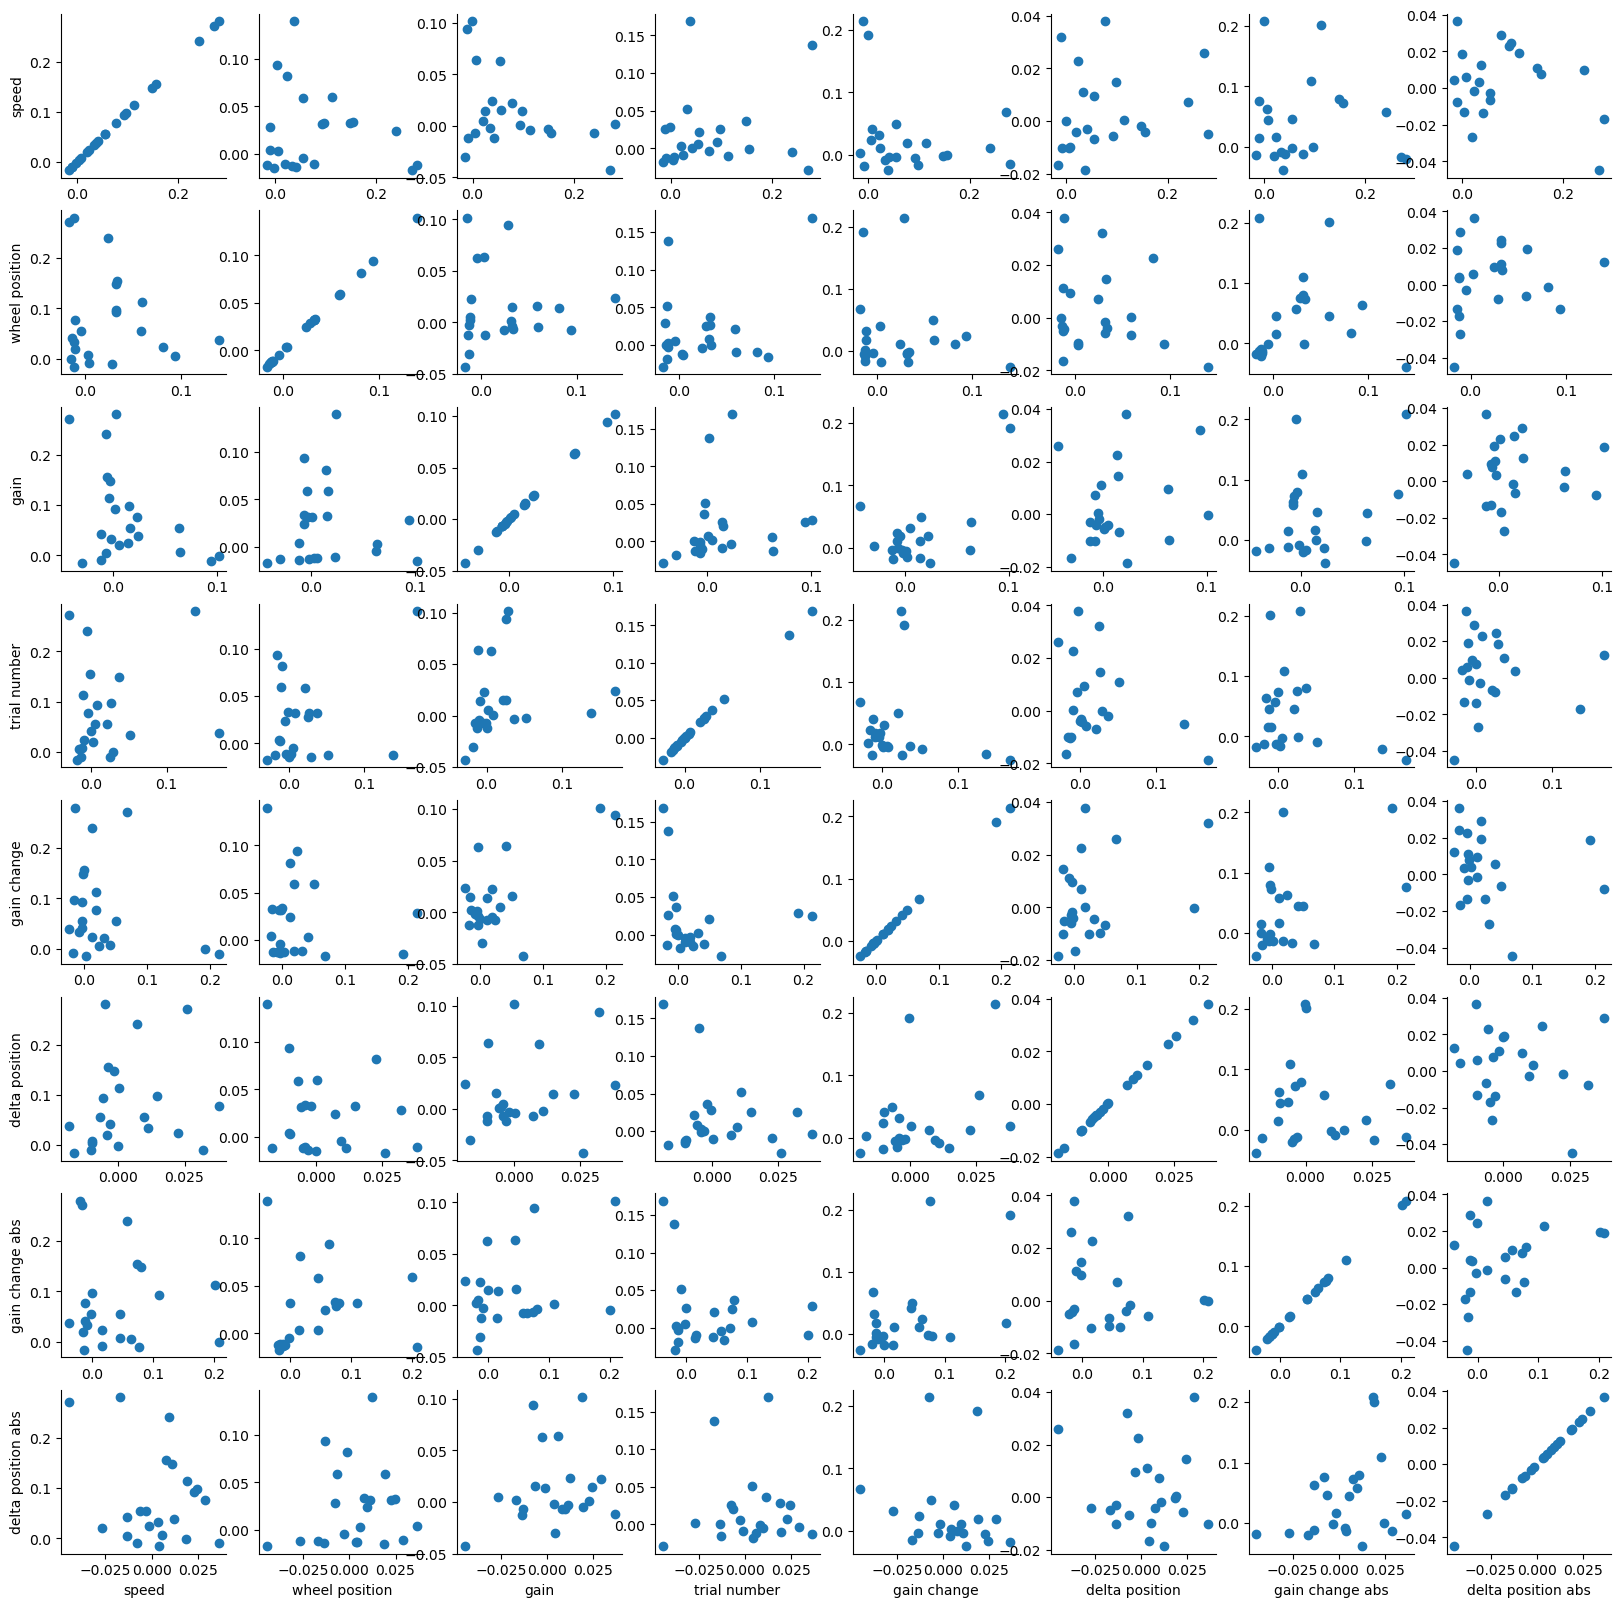

In [206]:
df_results_1 = df_results.copy().drop(columns='reducedR2')
df_results_1.index = df_results_1.index.set_names(['uid'])
df_results_1 = df_results_1.reset_index()
df_results_1 = df_results_1.groupby(['label','uid']).mean().reset_index()
df_results_1

f,axs = plt.subplots(8,8,figsize=(20,20))
for i in range(8):
    for j in range(8):
        axs[i,j].scatter(df_results_1[df_results_1['label'] == regressors_labels[i]]['cvR2'],df_results_1[df_results_1['label'] == regressors_labels[j]]['cvR2'])
    axs[i,0].set_ylabel(regressors_labels[i])
for j in range(8):
    axs[7,j].set_xlabel(regressors_labels[j])
plt.show()